In [1]:
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import seaborn as sns

In [2]:
# Configure GPU memory growth to prevent OOM errors
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"Error setting memory growth: {e}")

# Check for GPU availability
tf.keras.mixed_precision.set_global_policy('mixed_float16')

print("GPU Available: ", tf.config.list_physical_devices('GPU'))

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Set random seeds for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

# ======= Hyperparams =======
epochs = 10
num_words = 20000
maxlen = 100  # Max sequence length
batch_size = 64
embedding_dim = 64
hidden_dim = 128
num_layers = 2
dropout_prob = 0.3

# ======= Load & Preprocess Sarcasm Dataset =======
def preprocess_text(text):
    if isinstance(text, str):
        # Convert to lowercase
        text = text.lower()
        # Remove special characters and numbers
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        word_tokens = word_tokenize(text)
        text = ' '.join([w for w in word_tokens if w not in stop_words])
        return text
    else:
        return ""  # Return empty string for NaN values

df = pd.read_json('DeteksiSarkasme.json', lines=True)

# Check the structure of the dataset
print("Dataset columns:", df.columns.tolist())
print(f"Dataset size: {len(df)} rows")
print(df.head())

# Expecting the dataset to have 'headline' (or similar text field) and 'is_sarcastic' columns
# Adjust these according to your dataset
text_col = 'headline' if 'headline' in df.columns else 'text'
label_col = 'is_sarcastic'

df[text_col] = df[text_col].apply(lambda x: x.lower())
df[text_col] = df[text_col].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

# Handle missing values
df[text_col] = df[text_col].fillna("")

# Preprocess headlines/texts
df['processed_text'] = df[text_col].apply(preprocess_text)

# Build vocabulary from the dataset
def build_vocab(texts, max_words=num_words):
    all_words = ' '.join(texts).split()
    word_counts = Counter(all_words)
    # Sort words by frequency
    vocab = {word: idx+1 for idx, (word, _) in 
             enumerate(word_counts.most_common(max_words-1))}
    # Add padding token
    vocab['<PAD>'] = 0
    return vocab

# Create vocabulary
vocabulary = build_vocab(df['processed_text'].tolist(), max_words=num_words)
vocab_size = len(vocabulary)
print(f"Vocabulary size: {vocab_size}, maxlen: {maxlen}")

# Convert texts to sequences
def text_to_sequence(text, vocab, maxlen):
    words = text.split()
    sequence = [vocab.get(word, 0) for word in words]  # Use 0 for OOV words
    # Pad or truncate to maxlen
    if len(sequence) > maxlen:
        sequence = sequence[:maxlen]
    else:
        sequence = sequence + [0] * (maxlen - len(sequence))
    return sequence

# Create sequences
df['sequence'] = df['processed_text'].apply(lambda x: text_to_sequence(x, vocabulary, maxlen))

# Split data
X = np.array(df['sequence'].tolist())
y = np.array(df[label_col].tolist())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\muham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Dataset columns: ['article_link', 'headline', 'is_sarcastic']
Dataset size: 26709 rows
                                        article_link  \
0  https://www.huffingtonpost.com/entry/versace-b...   
1  https://www.huffingtonpost.com/entry/roseanne-...   
2  https://local.theonion.com/mom-starting-to-fea...   
3  https://politics.theonion.com/boehner-just-wan...   
4  https://www.huffingtonpost.com/entry/jk-rowlin...   

                                            headline  is_sarcastic  
0  former versace store clerk sues over secret 'b...             0  
1  the 'roseanne' revival catches up to our thorn...             0  
2  mom starting to fear son's web series closest ...             1  
3  boehner just wants wife to listen, not come up...             1  
4  j.k. rowling wishes snape happy birthday in th...             0  
Vocabulary size: 20000, maxlen: 100
Train size: 21367, Test size: 5342


# RNN Model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          1280000   
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 128)         24704     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 128)         32896     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

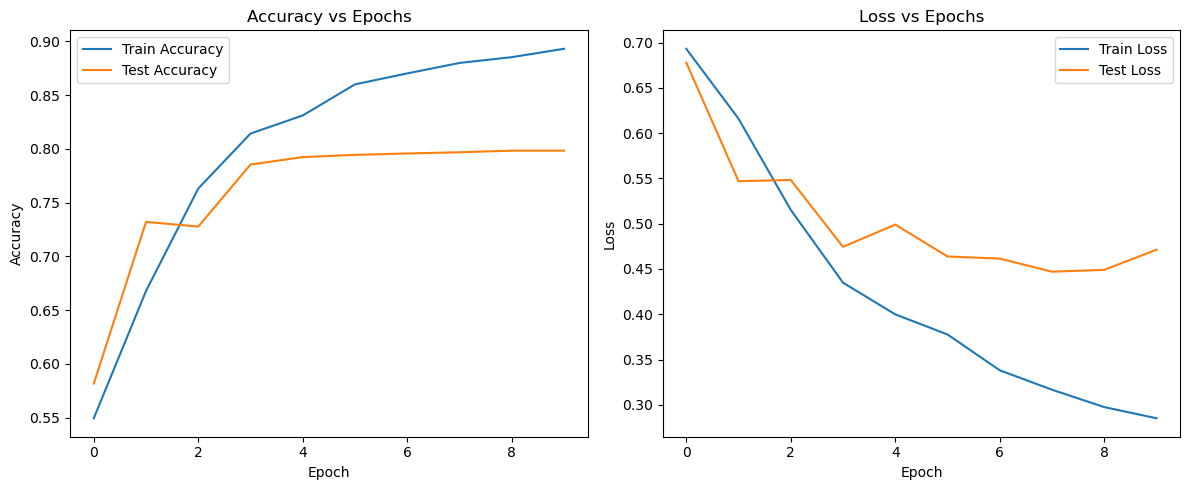

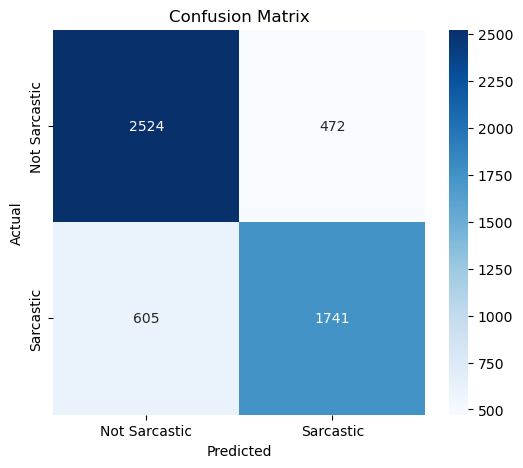

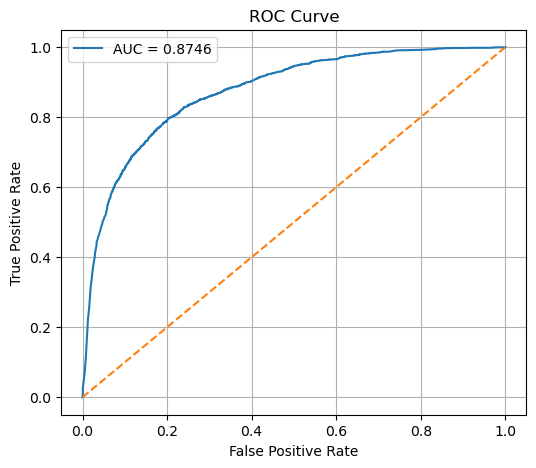

In [3]:
# ======= Build TensorFlow SimpleRNN Model =======
def build_rnn_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add SimpleRNN layers
    for i in range(num_layers - 1):
        model.add(SimpleRNN(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last RNN layer with return_sequences=True to get all outputs
    model.add(SimpleRNN(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(32, activation="relu"))

    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_rnn_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# LSTM Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         98816     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

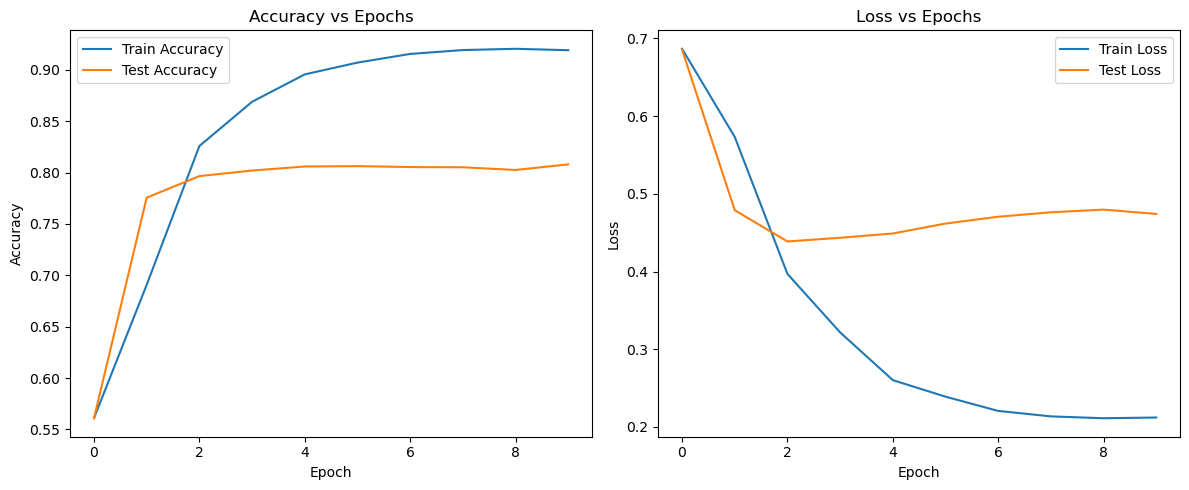

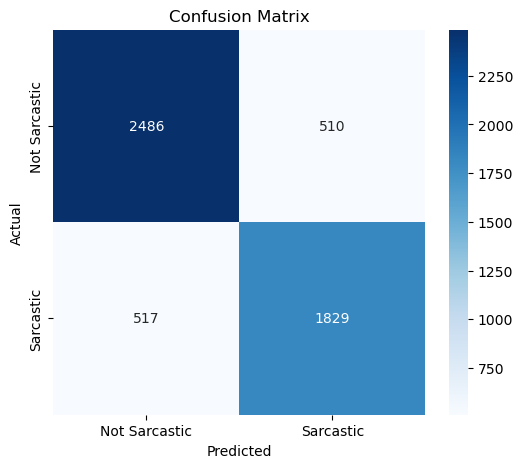

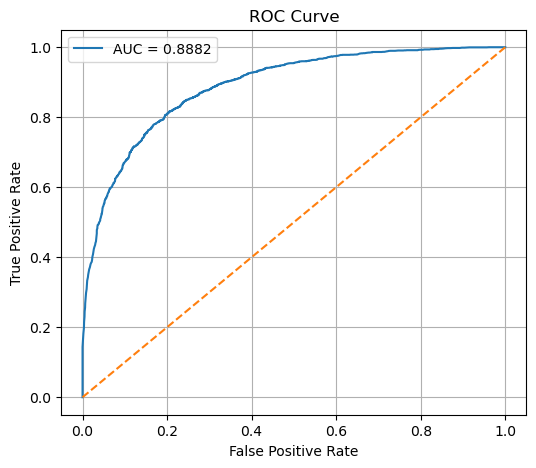

In [4]:
# ======= Build TensorFlow LSTM Model =======
def build_LSTM_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add LSTM layers
    for i in range(num_layers - 1):
        model.add(LSTM(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last LSTM layer with return_sequences=True to get all outputs
    model.add(LSTM(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))

    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_LSTM_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# GRU Model

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          1280000   
_________________________________________________________________
gru (GRU)                    (None, None, 128)         74496     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 128)         99072     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

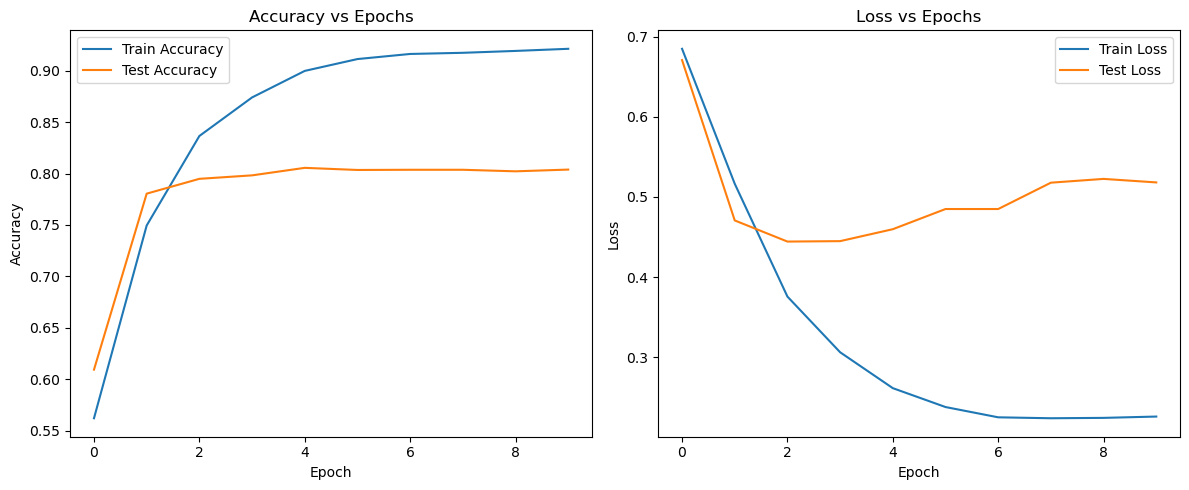

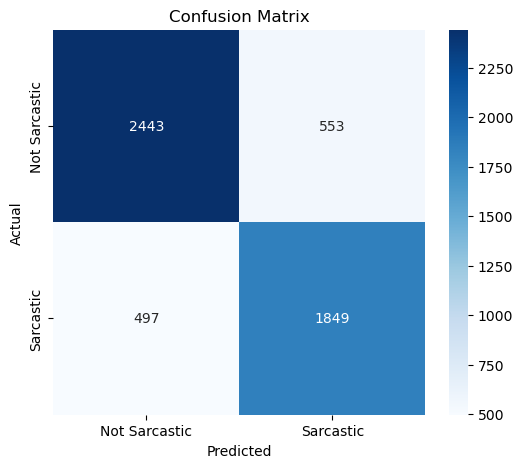

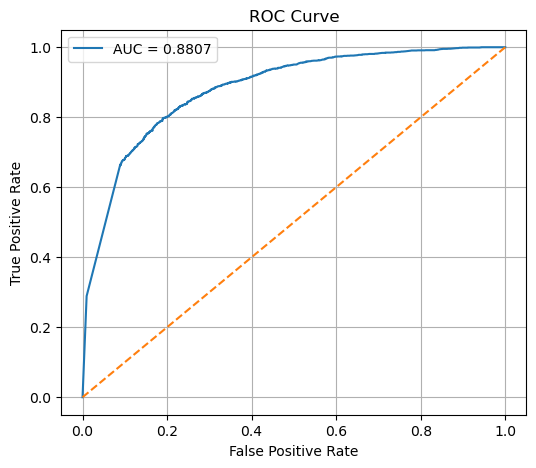

In [5]:
# ======= Build TensorFlow GRU Model =======
def build_GRU_model(vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.3):
    model = Sequential()
    
    # Add embedding layer
    model.add(Embedding(vocab_size, embed_dim, mask_zero=False))
    
    # Add GRU layers
    for i in range(num_layers - 1):
        model.add(GRU(hidden_dim, 
                            return_sequences=True,
                            dropout=dropout,
                            kernel_initializer='orthogonal',
                            recurrent_initializer='orthogonal',
                            bias_initializer='zeros'))
    
    # Last GRU layer with return_sequences=True to get all outputs
    model.add(GRU(hidden_dim, 
                      return_sequences=True,
                      dropout=dropout,
                      kernel_initializer='orthogonal',
                      recurrent_initializer='orthogonal',
                      bias_initializer='zeros'))
    
    # Global Max Pooling to get the most important features
    model.add(GlobalMaxPooling1D())

    model.add(Dense(128, activation="relu"))

    # Dropout before final layer
    model.add(Dropout(dropout))
    
    # Final dense layer with sigmoid activation for binary classification
    model.add(Dense(1, activation='sigmoid', 
                  kernel_initializer='glorot_uniform',
                  bias_initializer='zeros'))
    
    return model

# Create the model
model = build_GRU_model(vocab_size, embedding_dim, hidden_dim, num_layers, dropout_prob)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Create callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr],
    verbose=1
)

# ======= Evaluate the model =======
# Get predictions
y_prob = model.predict(X_test)
y_pred = (y_prob >= 0.5).astype(int).flatten()

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

print(f"\nFinal Evaluation on Test Set:")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1 Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ======= Visualization =======
# Plot training history
plt.figure(figsize=(12, 5))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs Epochs')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs Epochs')

plt.tight_layout()
plt.show()

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Sarcastic', 'Sarcastic'],
            yticklabels=['Not Sarcastic', 'Sarcastic'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

# Penjelasan Model, Visualisasi, dan Metrik

## 1. RNN (Recurrent Neural Network)

RNN menggunakan mekanisme **recurrence** untuk mengolah data urut seperti teks atau waktu. Formula utama yang digunakan dalam RNN adalah:

### Persamaan Dasar:
- **State Update**:
  $$
  h_t = f(W_h \cdot h_{t-1} + W_x \cdot x_t + b)
  $$
  - **Penjelasan**:
    - \($h_t$\): State tersembunyi pada waktu \(t\).
    - \($x_t$\): Input saat waktu \(t\).
    - \($W_h$\), \($W_x$\): Matriks bobot untuk state sebelumnya dan input saat ini.
    - \($b$\): Bias.
    - \($f$\): Fungsi aktivasi (contoh: tanh atau ReLU).

### Alur:
Pada setiap langkah waktu, RNN memperbarui state tersembunyi \($h_t$\) menggunakan input saat itu \($x_t$\) dan state sebelumnya \($h_{t-1}$\).

---

## 2. LSTM (Long Short-Term Memory)

LSTM mengatasi masalah **vanishing gradient** yang sering dialami RNN dengan menggunakan **gate mechanism**.

### Persamaan Dasar:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)
   $$
   - **Fungsi**: Memutuskan informasi mana yang harus dibuang dari memori.

2. **Input Gate**:
   $$
   i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_C \cdot [h_{t-1}, x_t] + b_C)
   $$
   - **Fungsi**: Menghitung memori baru yang akan ditambahkan.

3. **Cell State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   - **Fungsi**: Memperbarui state sel.

4. **Output Gate**:
   $$
   o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o)
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$
   - **Fungsi**: Menghitung keluaran berdasarkan state sel yang diperbarui.

---

## 3. GRU (Gated Recurrent Unit)

GRU adalah versi sederhana dari LSTM tanpa cell state terpisah. Persamaan yang digunakan:

### Persamaan Dasar:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_r \cdot [h_{t-1}, x_t] + b_r)
   $$
   - **Fungsi**: Memutuskan informasi masa lalu yang harus dilupakan.

2. **Update Gate**:
   $$
   z_t = \sigma(W_z \cdot [h_{t-1}, x_t] + b_z)
   $$
   - **Fungsi**: Mengontrol berapa banyak informasi dari masa lalu yang akan dibawa ke state saat ini.

3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_h \cdot [r_t \odot h_{t-1}, x_t] + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$
   - **Fungsi**: State tersembunyi diperbarui menggunakan reset dan update gate.

---

## 4. Visualisasi

### Akurasi:
Akurasi dihitung sebagai:
$$
\text{Accuracy} = \frac{\text{Jumlah Prediksi Benar}}{\text{Total Sampel}}
$$

### Loss:
Loss dalam pelatihan model dihitung menggunakan fungsi **Binary Cross Entropy (BCE)**:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya.
- \($\hat{y}_i$\): Probabilitas prediksi model.

### ROC Curve:
ROC Curve menunjukkan hubungan antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**:
- **TPR**:
  $$
  TPR = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$
- **FPR**:
  $$
  FPR = \frac{\text{False Positives}}{\text{False Positives} + \text{True Negatives}}
  $$

### AUC (Area Under Curve):
AUC mengukur area di bawah ROC Curve:
$$
\text{AUC} = \int_{0}^{1} TPR(FPR) \,dFPR
$$
Nilai AUC berkisar antara 0 hingga 1, dengan 1 menunjukkan prediksi sempurna.

---

## 5. Metrik

### Precision:
Precision mengukur seberapa tepat model dalam prediksi kelas positif:
$$
\text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
$$

### Recall:
Recall mengukur kemampuan model untuk mendeteksi semua kelas positif:
$$
\text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
$$

### F1 Score:
F1 Score adalah rata-rata harmonis antara precision dan recall:
$$
\text{F1 Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

---

# Penjelasan Matematika PyTorch

## 1. Embedding Layer
Layer **`nn.Embedding`** digunakan untuk mengubah input indeks menjadi representasi vektor yang dapat dipelajari:
$$
E(x_t) = W_{embedding} \cdot x_t
$$
- **Dimensi**:
  - \($x_t$\): Input berupa indeks kata, dengan dimensi \($(batch\_size, sequence\_length)$\).
  - \($W_{embedding}$\): Matriks bobot dengan ukuran \($(\text{vocab\_size}, \text{embed\_dim})$\).
  - Output: Tensor dengan dimensi \($(batch\_size, sequence\_length, \text{embed\_dim})$\).

PyTorch secara otomatis memperbarui \($W_{embedding}$\) selama pelatihan untuk menghasilkan representasi kata yang bermakna.

---

## 2. RNN, GRU, dan LSTM
### **a. RNN (`nn.RNN`)**
Recurrent Neural Network (RNN) digunakan untuk memproses data sekuensial. Persamaan matematisnya adalah:
$$
h_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot h_{t-1} + b_h)
$$
- \($h_t$\): State tersembunyi pada waktu \($t$\).
- \($W_{ih}$\): Bobot input ke hidden state (\($\text{input\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($W_{hh}$\): Bobot antara hidden state (\($\text{hidden\_dim}$ $\to$ $\text{hidden\_dim}$\)).
- \($b_h$\): Bias.
- Fungsi aktivasi: **tanh**.

Output RNN adalah state tersembunyi pada setiap langkah waktu.

---

### **b. GRU (`nn.GRU`)**
GRU menggunakan mekanisme gate untuk menangani vanishing gradient:
1. **Reset Gate**:
   $$
   r_t = \sigma(W_{ir} \cdot x_t + W_{hr} \cdot h_{t-1} + b_r)
   $$
   - Mengontrol seberapa banyak informasi masa lalu yang dilupakan.
2. **Update Gate**:
   $$
   z_t = \sigma(W_{iz} \cdot x_t + W_{hz} \cdot h_{t-1} + b_z)
   $$
   - Mengontrol informasi baru yang ditambahkan ke state.
3. **State Update**:
   $$
   \tilde{h}_t = \text{tanh}(W_{ih} \cdot x_t + W_{hh} \cdot (r_t \odot h_{t-1}) + b_h)
   $$
   $$
   h_t = (1 - z_t) \cdot h_{t-1} + z_t \cdot \tilde{h}_t
   $$

PyTorch menangani semua kalkulasi ini secara otomatis dalam layer GRU.

---

### **c. LSTM (`nn.LSTM`)**
LSTM memiliki struktur yang lebih kompleks dibanding GRU, dengan 3 jenis gate:
1. **Forget Gate**:
   $$
   f_t = \sigma(W_{if} \cdot x_t + W_{hf} \cdot h_{t-1} + b_f)
   $$
2. **Input Gate**:
   $$
   i_t = \sigma(W_{ii} \cdot x_t + W_{hi} \cdot h_{t-1} + b_i)
   $$
   $$
   \tilde{C}_t = \text{tanh}(W_{ic} \cdot x_t + W_{hc} \cdot h_{t-1} + b_c)
   $$
3. **Output Gate**:
   $$
   o_t = \sigma(W_{io} \cdot x_t + W_{ho} \cdot h_{t-1} + b_o)
   $$
4. **State Update**:
   $$
   C_t = f_t \cdot C_{t-1} + i_t \cdot \tilde{C}_t
   $$
   $$
   h_t = o_t \cdot \text{tanh}(C_t)
   $$

Di PyTorch, `nn.LSTM` mengelola kedua state (\($h_t$\), \($C_t$\)) secara otomatis.

---

## 3. Dropout (`nn.Dropout`)
Layer `nn.Dropout` digunakan untuk regularisasi. Operasinya dapat dirumuskan sebagai:
$$
d_t = M \cdot h_t
$$
- \($M$\): Mask binari yang dihasilkan dengan probabilitas \($p$\) untuk dropout.

Dropout diaktifkan selama pelatihan (`model.train()`) tetapi tidak diterapkan saat evaluasi (`model.eval()`).

---

## 4. Fully Connected Layers (`nn.Linear`)
Layer `nn.Linear` adalah transformasi linier sederhana:
$$
y_t = W \cdot h_t + b
$$
- \($W$\): Matriks bobot (\($\text{hidden\_dim} \to \text{output\_dim}$\)).
- \($b$\): Bias.

Fungsi aktivasi seperti `ReLU` atau `Sigmoid` diterapkan setelah `nn.Linear` untuk menambahkan non-linearitas.

---

## 5. Binary Cross-Entropy Loss (BCELoss)
Loss dihitung menggunakan rumus:
$$
\text{BCE Loss} = -\frac{1}{N} \sum_{i=1}^{N} \big[y_i \cdot \log(\hat{y}_i) + (1 - y_i) \cdot \log(1 - \hat{y}_i)\big]
$$
- \($y_i$\): Label sebenarnya (0 atau 1).
- \($\hat{y}_i$\): Probabilitas prediksi setelah fungsi sigmoid.

---

## 6. GradScaler
PyTorch mendukung precision campuran dengan `torch.amp.GradScaler` untuk mencegah angka terlalu kecil atau besar:
- **Forward Pass**:
  $$ \text{loss} = \text{criterion}(output, label) $$
- **Gradient Scaling**:
  $$ \text{scaled\_loss} = \text{scale} \cdot \text{loss} $$
- Setelah backward pass:
  $$ \text{gradients} = \frac{\partial (\text{scaled\_loss})}{\partial (\text{parameters})} $$

Scaler memperbarui bobot sambil mempertahankan stabilitas numerik.

---

## 7. ReduceLROnPlateau
Scheduler ini mengurangi learning rate berdasarkan stagnasi pada loss validasi:
$$
\text{lr\_new} = \text{lr\_old} \times \text{factor}
$$
Dengan **PyTorch**:
```python
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=1, factor=0.5)
scheduler.step(test_loss)
